# Smart Urban Heat Map zu SensorThings API Konverter

Dieses Notebook demonstriert, wie Daten aus der Smart Urban Heat Map API abgerufen und in das SensorThings API Format überführt werden.

### Verwendete Python-Bibliotheken:

- `json`: Verarbeitung von JSON-Daten (z. B. für API-Antworten oder Dateispeicherung)
- `requests`: HTTP-Anfragen an Web-APIs
- `pandas`: Tabellenartige Datenverarbeitung (DataFrames)
- `geopandas`: Erweiterung von pandas für Geodaten (GeoDataFrames, shapefiles, etc.)
- `shapely.geometry.Point`: Repräsentation von Punktgeometrien (z. B. Koordinaten)
- `folium`: Darstellung interaktiver Karten mit Leaflet.js (Marker, Farbcodierung etc.)
- `branca`: Zusatztools für `folium`, z. B. Farbskalen (Colormap)
- `matplotlib.pyplot`: Visualisierung von Zeitreihen (Diagramme, Plots)

In [1]:
import argparse
import json
import requests
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import folium
import branca
import matplotlib.pyplot as plt

## API-Klassen zur Datenabfrage und Vorverarbeitung

Die folgenden Klassen kapseln die HTTP-Kommunikation mit der Smart Urban Heat Map API, 
verarbeiten GeoJSON-Antworten und erzeugen daraus strukturierte SensorThings-Entitäten.

In [2]:
class SmartUrbanHeatMapClient:
    """
    Verantwortlich für HTTP-Kommunikation mit der Smart Urban Heat Map API.
    """
    def __init__(self, base_url: str = "https://smart-urban-heat-map.ch/api/v2"):
        self.base_url = base_url

    def fetch_latest(self) -> str:
        """Holt das rohe GeoJSON vom /latest-Endpoint als String."""
        url = f"{self.base_url}/latest"
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    
    
class GeoDataLoader:
    """
    Verantwortlich für das Einlesen und Vorverarbeiten von GeoJSON-Strings in ein GeoDataFrame.
    """
    def load(self, geojson_str: str) -> gpd.GeoDataFrame:
        data = json.loads(geojson_str)
        crs = data.get('crs', {}).get('properties', {}).get('name', None)
        gdf = gpd.GeoDataFrame.from_features(data, crs=crs)
        return gdf
    
    
class ThingBuilder:
    """
    Baut die "Things"-Entitäten aus den Daten.
    """
    def build(self, df: pd.DataFrame) -> list:
        things = []
        for _, row in df.iterrows():
            things.append({
                "@iot.id": row.get("stationId"),
                "name": row.get("name", ""),
                "description": "Sensor station measuring temperature and humidity",
                "properties": {
                    "outdated": row.get("outdated"),
                    "measurementsPlausible": row.get("measurementsPlausible")
                }
            })
        return things
    

class LocationBuilder:
    """
    Baut die "Locations"-Entitäten aus geometrischen Daten.
    """
    def build(self, df: pd.DataFrame) -> list:
        locations = []
        for _, row in df.iterrows():
            geom = row.get("geometry")
            if not isinstance(geom, Point):
                continue
            coords = [geom.x, geom.y]
            locations.append({
                "@iot.id": row.get("stationId"),
                "name": row.get("name", ""),
                "description": "Geographic location of the sensor",
                "encodingType": "application/vnd.geo+json",
                "location": {"type": "Point", "coordinates": coords}
            })
        return locations


class DataStreamBuilder:
    """
    Baut die "Datastreams"-Entitäten für Temperatur und Feuchte.
    """
    def build(self, df: pd.DataFrame) -> list:
        dstreams = []
        for _, row in df.iterrows():
            sid = row.get("stationId")
            name = row.get("name", "")
            # Temperatur-Datastream
            dstreams.append({
                "@iot.id": f"{sid}-temperature",
                "name": f"Temperature Datastream for {name}",
                "description": "Temperature measurements",
                "unitOfMeasurement": {"symbol": "°C", "name": "Degree Celsius", "definition": "http://unitsofmeasure.org/ucum.html#para-30"},
                "observationType": "http://www.opengis.net/def/observationType/OGC-OM/2.0/OM_Measurement",
                "Thing": {"@iot.id": sid},
                "ObservedProperty": {"name": "Temperature", "definition": "http://sensorthings.org/Temperature"},
                "Sensor": {"name": "Temperature Sensor", "description": "Measures air temperature"}
            })
            # Luftfeuchtigkeit-Datastream
            dstreams.append({
                "@iot.id": f"{sid}-humidity",
                "name": f"Humidity Datastream for {name}",
                "description": "Humidity measurements",
                "unitOfMeasurement": {"symbol": "%", "name": "Percentage", "definition": "http://unitsofmeasure.org/ucum.html#para-30"},
                "observationType": "http://www.opengis.net/def/observationType/OGC-OM/2.0/OM_Measurement",
                "Thing": {"@iot.id": sid},
                "ObservedProperty": {"name": "Humidity", "definition": "http://sensorthings.org/Humidity"},
                "Sensor": {"name": "Humidity Sensor", "description": "Measures relative humidity"}
            })
        return dstreams
    

class ObservationBuilder:
    """
    Erstellt die "Observations"-Einträge mit Zeitstempeln und Ergebnissen.
    """
    def build(self, df: pd.DataFrame) -> list:
        observations = []
        for _, row in df.iterrows():
            sid = row.get("stationId")
            ts = row.get("dateObserved")
            ts_iso = ts.isoformat() if hasattr(ts, 'isoformat') else str(ts)
            # Temperatur-Observation
            observations.append({
                "Datastream": {"@iot.id": f"{sid}-temperature"},
                "phenomenonTime": ts_iso,
                "resultTime": ts_iso,
                "result": row.get("temperature")
            })
            # Feuchte-Observation
            observations.append({
                "Datastream": {"@iot.id": f"{sid}-humidity"},
                "phenomenonTime": ts_iso,
                "resultTime": ts_iso,
                "result": row.get("relativeHumidity")
            })
        return observations
    

class SensorThingsConverter:
    """
    Fassade, die alle Komponenten orchestriert: Ruft Daten von der SmartUrbanHeatMapClient ab und erzeugt SensorThings-konforme Objekte.
    """
    def __init__(self, base_url: str = None):
        client_url = base_url if base_url else "https://smart-urban-heat-map.ch/api/v2"
        self.client = SmartUrbanHeatMapClient(client_url)
        self.loader = GeoDataLoader()
        self.thing_builder = ThingBuilder()
        self.location_builder = LocationBuilder()
        self.datastream_builder = DataStreamBuilder()
        self.observation_builder = ObservationBuilder()

    def convert(self) -> dict:
        raw = self.client.fetch_latest()
        df = self.loader.load(raw)
        return {
            "Things": self.thing_builder.build(df),
            "Locations": self.location_builder.build(df),
            "Datastreams": self.datastream_builder.build(df),
            "Observations": self.observation_builder.build(df)
        }

    def save_to_json(self, filename="sensor_things_output.json"):
        payload = self.convert()
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(payload, f, ensure_ascii=False, indent=4)
        print(f"SensorThings-Daten wurden erfolgreich in {filename} gespeichert.")

### Ausführung der Konvertierung und Export der Daten

In diesem abschliessenden Block wird die komplette Verarbeitungskette ausgeführt:

- Es wird ein `SensorThingsConverter` erstellt
- Die aktuellen Daten von der Smart Urban Heat Map API werden abgerufen
- Die Daten werden in das SensorThings-Format umgewandelt
- Das Ergebnis wird als JSON-Datei (`sensor_things_output.json`) gespeichert

In [3]:
# Optionaler direkter Aufruf für Tests oder interaktive Nutzung
if __name__ == "__main__":
    converter = SensorThingsConverter()
    converter.save_to_json("sensor_things_output.json")

SensorThings-Daten wurden erfolgreich in sensor_things_output.json gespeichert.


### Interaktive Darstellung der SensorStandorte (SensorThings)

In diesem Abschnitt wird die zuvor erzeugte `sensor_things_output.json`-Datei geladen und auf einer interaktiven Karte dargestellt.

Dabei wird:
- das SensorThings-konforme JSON eingelesen,
- die relevanten Informationen zu Sensorstandorten und Temperatur extrahiert,
- ein GeoDataFrame erstellt,
- und mit `folium` eine farbcodierte Karte erzeugt, auf der jede Station als Marker mit Temperaturanzeige erscheint.

In [4]:
# SensorThings JSON laden
with open("sensor_things_output.json", "r") as f:
    data = json.load(f)

# 1. Things laden
things = {thing["@iot.id"]: thing["name"] for thing in data["Things"]}

# 2. Locations laden
locations = data["Locations"]
location_entries = []
for loc in locations:
    thing_id = str(loc["@iot.id"])
    coords = loc["location"]["coordinates"]
    location_entries.append({
        "id": thing_id,
        "name": loc["name"],
        "lon": coords[0],
        "lat": coords[1]
    })

# 3. Temperaturwerte aus Observations extrahieren
observations = data.get("Observations", [])
temperature_map = {}

for obs in observations:
    datastream = obs.get("Datastream", {})
    ds_id = datastream.get("@iot.id", "")
    if "-temperature" in ds_id:
        thing_id = ds_id.replace("-temperature", "")
        temperature_map[thing_id] = obs["result"]

# 4. DataFrame erstellen mit echten Temperaturen
df = pd.DataFrame(location_entries)
df["temperature"] = df["id"].map(temperature_map)
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
stations = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# 5. Karte erzeugen
m = folium.Map(location=[stations.geometry.y.mean(), stations.geometry.x.mean()], zoom_start=13)

# 6. Farbskala
def reversed_colormap(existing):
    return branca.colormap.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax
    )

colormap = reversed_colormap(branca.colormap.linear.Spectral_04)
colormap = colormap.scale(10, 40).to_step(9)
colormap.caption = "Temperature (°C)"
colormap.add_to(m)

# 7. Marker auf Karte zeichnen
for idx, station in stations.iterrows():
    if pd.notnull(station["temperature"]):
        folium.CircleMarker(
            location=(station.geometry.y, station.geometry.x),
            radius=5,
            color="black",
            weight=0.5,
            fill=True,
            fill_color=colormap(station['temperature']),
            fill_opacity=1,
            tooltip=f"{station['name']}: {station['temperature']:.2f}°C",
        ).add_to(m)

# 8. Karte anzeigen
m

#### Interaktive Darstellung der SensorStandorte (SensorThings) mit Temperatur und Luftfeuchtigkeit

In [5]:
# SensorThings JSON laden
with open("sensor_things_output.json", "r") as f:
    data = json.load(f)

# 1. Things laden
things = {thing["@iot.id"]: thing["name"] for thing in data["Things"]}

# 2. Locations laden
locations = data["Locations"]
location_entries = []
for loc in locations:
    thing_id = str(loc["@iot.id"])
    coords = loc["location"]["coordinates"]
    location_entries.append({
        "id": thing_id,
        "name": loc["name"],
        "lon": coords[0],
        "lat": coords[1]
    })

# 3. Temperatur & Humidity aus Observations extrahieren
observations = data.get("Observations", [])
temperature_map = {}
humidity_map = {}

for obs in observations:
    ds_id = obs.get("Datastream", {}).get("@iot.id", "")
    if "-temperature" in ds_id:
        thing_id = ds_id.replace("-temperature", "")
        temperature_map[thing_id] = obs["result"]
    elif "-humidity" in ds_id:
        thing_id = ds_id.replace("-humidity", "")
        humidity_map[thing_id] = obs["result"]

# 4. DataFrame mit Temperatur + Luftfeuchtigkeit
df = pd.DataFrame(location_entries)
df["temperature"] = df["id"].map(temperature_map)
df["humidity"] = df["id"].map(humidity_map)
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
stations = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# 5. Karte erzeugen
m = folium.Map(location=[stations.geometry.y.mean(), stations.geometry.x.mean()], zoom_start=13)

# 6. Colormap für Temperatur
def reversed_colormap(existing):
    return branca.colormap.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax
    )

colormap = reversed_colormap(branca.colormap.linear.Spectral_04)
colormap = colormap.scale(15, 37).to_step(9)
colormap.caption = "Temperature (°C)"
colormap.add_to(m)

# 7. Marker mit Tooltip für Temperatur + Humidity
for idx, station in stations.iterrows():
    if pd.notnull(station["temperature"]):
        tooltip_text = f"{station['name']}<br>{station['temperature']:.2f}°C"
        if pd.notnull(station["humidity"]):
            tooltip_text += f"<br>{station['humidity']:.1f}%"
        folium.CircleMarker(
            location=(station.geometry.y, station.geometry.x),
            radius=5,
            color="black",
            weight=0.5,
            fill=True,
            fill_color=colormap(station['temperature']),
            fill_opacity=1,
            tooltip=tooltip_text,
        ).add_to(m)

# 8. Karte anzeigen
m


## Station Timeseries

Abruf und Umwandlung der Zeitreihendaten in das SensorThings-Datenformat

In [6]:
# Parameter
station_id = "11117"
start_time = "2024-11-01T00:00:00Z"
end_time = "2024-11-05T00:00:00Z"
output_file = f"timeseries_{station_id}.json"

In [7]:
# Daten von API holen und im SensorThings-Format speichern
url = f"https://smart-urban-heat-map.ch/api/v2/timeseries?stationId={station_id}&timeFrom={start_time}&timeTo={end_time}"
response = requests.get(url)
data = response.json()

# Umwandlung in SensorThings-Observations
observations = []
for entry in data.get("values", []):
    ts = pd.to_datetime(entry["dateObserved"]).isoformat()
    if "temperature" in entry:
        observations.append({
            "Datastream": {"@iot.id": f"{station_id}-temperature"},
            "phenomenonTime": ts,
            "resultTime": ts,
            "result": entry["temperature"]
        })
    if "relativeHumidity" in entry:
        observations.append({
            "Datastream": {"@iot.id": f"{station_id}-humidity"},
            "phenomenonTime": ts,
            "resultTime": ts,
            "result": entry["relativeHumidity"]
        })

# Speichern als JSON
with open(output_file, "w") as f:
    json.dump({"Observations": observations}, f, indent=2)
print(f"{len(observations)} Beobachtungen gespeichert in {output_file}")

556 Beobachtungen gespeichert in timeseries_11117.json


### Timeseries Beobachtung visualisieren

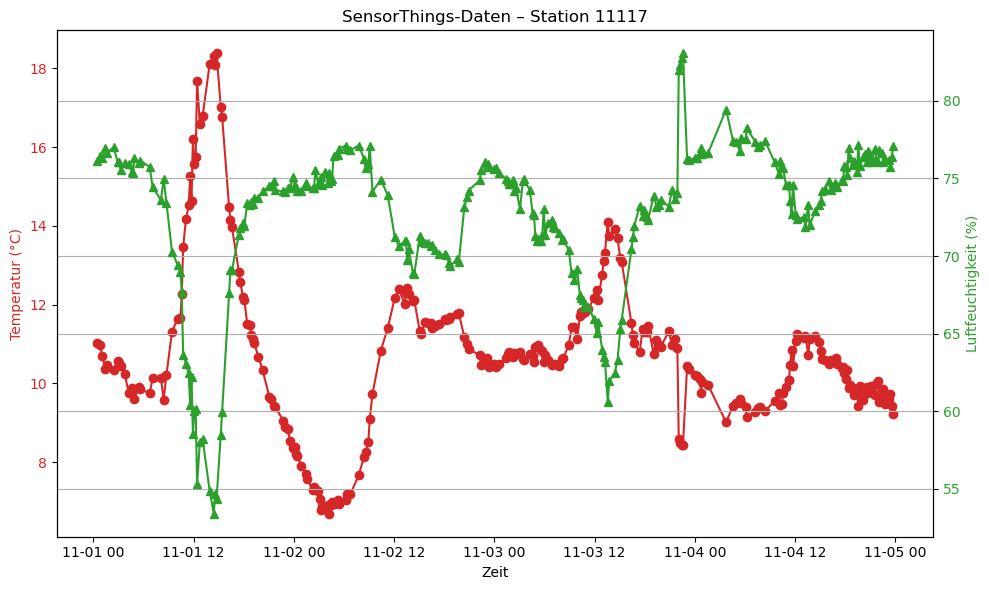

In [8]:
# Öffne die zuvor gespeicherte JSON-Datei mit den Observations
with open(output_file, "r") as f:
    obs_data = json.load(f)

# Zerlege die Observations in Temperatur- und Feuchtigkeitsmessungen
temp = []
hum = []
for obs in obs_data["Observations"]:
    ts = obs["phenomenonTime"]
    val = obs["result"]
    stream = obs["Datastream"]["@iot.id"]
    if "temperature" in stream:
        temp.append((ts, val))
    elif "humidity" in stream:
        hum.append((ts, val))

# Erzeuge separate DataFrames für Temperatur und Feuchtigkeit
df_temp = pd.DataFrame(temp, columns=["datetime", "temperature"])
df_hum = pd.DataFrame(hum, columns=["datetime", "humidity"])

# Wandle Zeitstempel in echte Datetime-Objekte um
df_temp["datetime"] = pd.to_datetime(df_temp["datetime"])
df_hum["datetime"] = pd.to_datetime(df_hum["datetime"])

# Füge beide DataFrames anhand der Zeitspalte zusammen
df = pd.merge(df_temp, df_hum, on="datetime")

# Erzeuge ein kombiniertes Diagramm mit zwei y-Achsen
fig, ax1 = plt.subplots(figsize=(10, 6))

# Zeichne die Temperatur (linke y-Achse)
color = "tab:red"
ax1.set_xlabel("Zeit")
ax1.set_ylabel("Temperatur (°C)", color=color)
ax1.plot(df["datetime"], df["temperature"], color=color, marker='o') # Linie mit Punkten
ax1.tick_params(axis="y", labelcolor=color)

# Erzeuge eine zweite y-Achse für die Luftfeuchtigkeit
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Luftfeuchtigkeit (%)", color=color)
ax2.plot(df["datetime"], df["humidity"], color=color, marker='^') # Linie mit Dreiecken
ax2.tick_params(axis="y", labelcolor=color)

# Füge einen Titel hinzu
plt.title("SensorThings-Daten – Station 11117")

# Zeige ein Raster im Hintergrund
plt.grid()

# Optimiere das Layout für bessere Darstellung
plt.tight_layout()

# Zeige die finale Visualisierung
plt.show()